# Test

In [9]:
%pip install pandas numpy matplotlib seaborn catboost statsmodels pmdarima tensorflow scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

Note: you may need to restart the kernel to use updated packages.


c:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


c:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 3\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 3\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 3\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 3\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\b1gtz\Desktop\IT Projects\Python\Intensive 3\.venv\Lib\site

Сравнение моделей по MAE:
CatBoost: 12389.39
ARIMA: 14476.35
LSTM: 2956.95


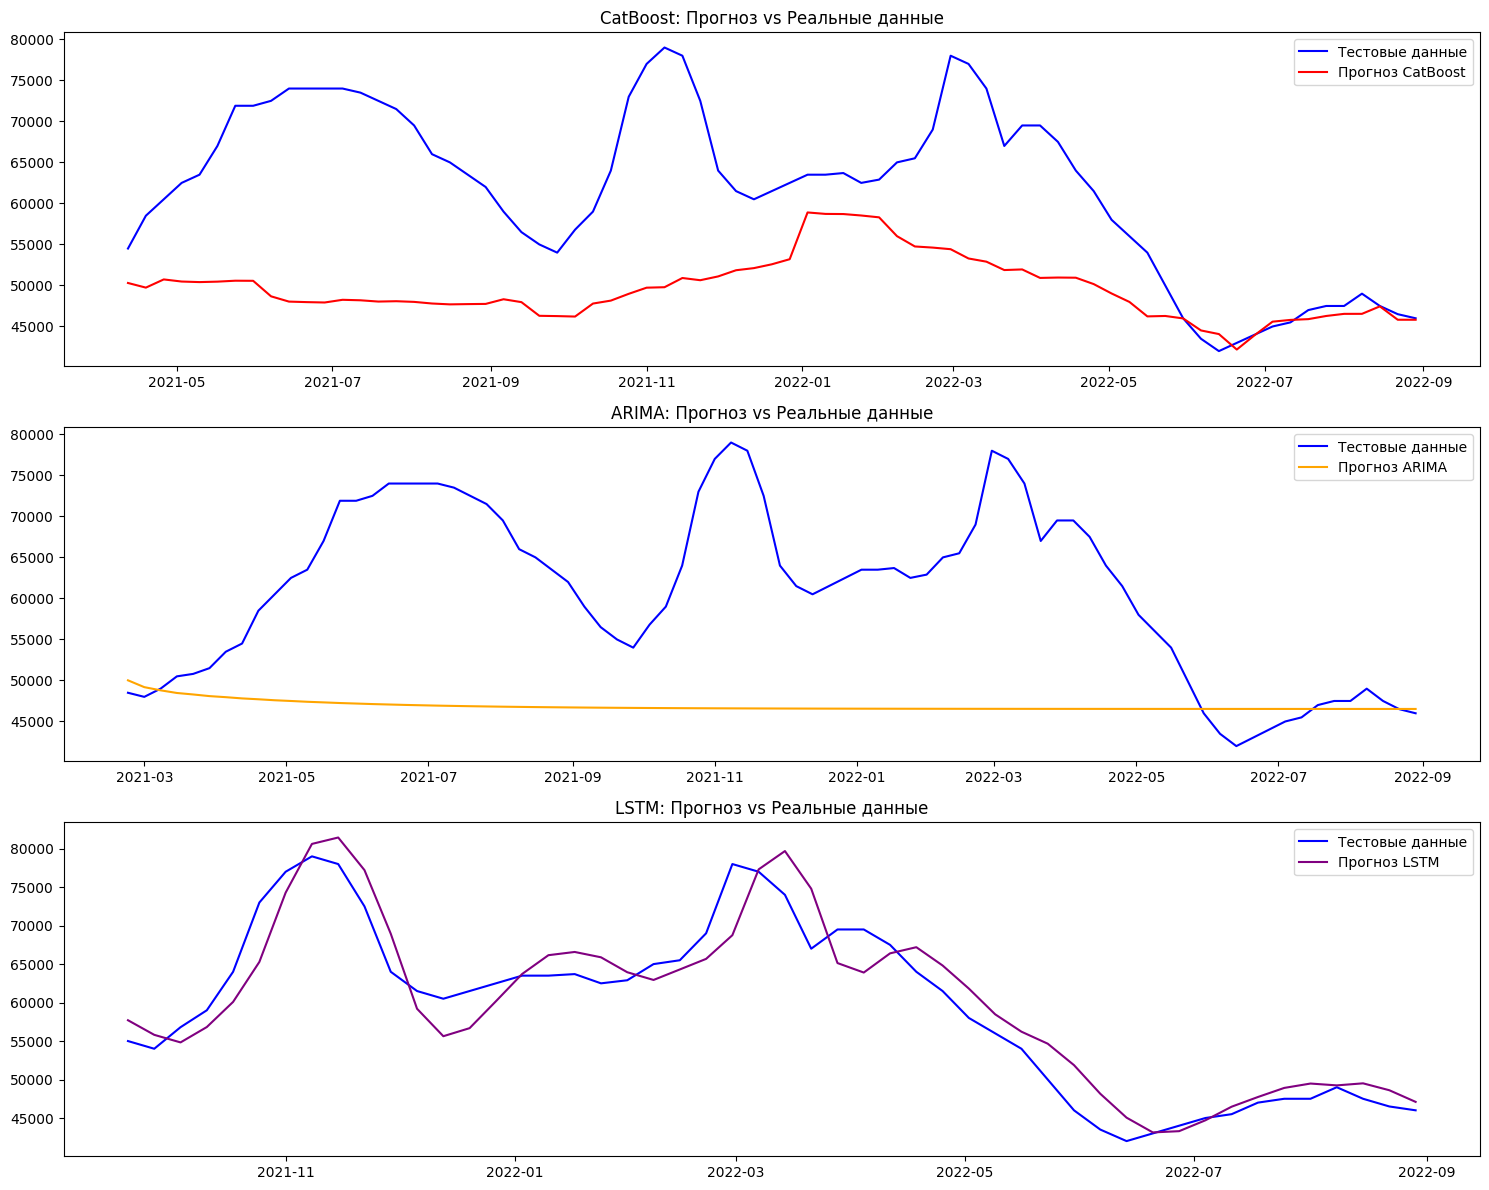

In [10]:
# Загружаем данные
train_path = "train.xlsx"
data = pd.read_excel(train_path, header=0)

# Подготовка данных
data.columns = data.columns.str.strip().str.lower()
column_mapping = {'dt': 'date', 'цена на арматуру': 'price'}
data.rename(columns=column_mapping, inplace=True)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Разделяем данные на тренировочную и тестовую выборки (80% / 20%)
train_data, test_data = data.iloc[:int(len(data) * 0.8)], data.iloc[int(len(data) * 0.8):]

# Нормализация данных для LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['price']])
test_scaled = scaler.transform(test_data[['price']])

# Функция для создания набора данных для LSTM
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

time_step = 30
X_train_lstm, y_train_lstm = create_dataset(train_scaled, time_step)
X_test_lstm, y_test_lstm = create_dataset(test_scaled, time_step)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Обучение LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0)

# Предсказания LSTM
test_preds_lstm = model_lstm.predict(X_test_lstm)
test_preds_lstm_rescaled = scaler.inverse_transform(test_preds_lstm)
y_test_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
lstm_mae = mean_absolute_error(y_test_rescaled, test_preds_lstm_rescaled)

# CatBoost
def add_features(data):
    data['price_lag_1'] = data['price'].shift(1)
    data['price_lag_7'] = data['price'].shift(7)
    data['rolling_mean_7'] = data['price'].rolling(window=7).mean()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['dayofyear'] = data.index.dayofyear
    return data

train_data_cb = add_features(train_data.copy())
test_data_cb = add_features(test_data.copy())
train_data_cb.dropna(inplace=True)
test_data_cb.dropna(inplace=True)

features = ['price_lag_1', 'price_lag_7', 'rolling_mean_7', 'year', 'month', 'dayofyear']
X_train_cb = train_data_cb[features]
y_train_cb = train_data_cb['price']
X_test_cb = test_data_cb[features]
y_test_cb = test_data_cb['price']

model_catboost = CatBoostRegressor(iterations=1000, learning_rate=0.03, depth=8, verbose=0)
model_catboost.fit(X_train_cb, y_train_cb)
test_preds_catboost = model_catboost.predict(X_test_cb)
catboost_mae = mean_absolute_error(y_test_cb, test_preds_catboost)

# ARIMA
def evaluate_arima(data_train, data_test):
    model = auto_arima(data_train['price'], seasonal=True, stepwise=True, suppress_warnings=True)
    predictions = model.predict(n_periods=len(data_test))
    mae = mean_absolute_error(data_test['price'], predictions)
    return predictions, mae

predictions_arima, arima_mae = evaluate_arima(train_data, test_data)

# Сравнение моделей
results = {
    'CatBoost': catboost_mae,
    'ARIMA': arima_mae,
    'LSTM': lstm_mae
}

# Вывод результатов
print("Сравнение моделей по MAE:")
for model, mae in results.items():
    print(f"{model}: {mae:.2f}")

# Графики прогнозов
plt.figure(figsize=(15, 12))

# CatBoost
plt.subplot(3, 1, 1)
plt.plot(test_data_cb.index, test_data_cb['price'], label='Тестовые данные', color='blue')
plt.plot(test_data_cb.index, test_preds_catboost[:len(test_data_cb)], label='Прогноз CatBoost', color='red')
plt.title('CatBoost: Прогноз vs Реальные данные')
plt.legend()

# ARIMA
plt.subplot(3, 1, 2)
plt.plot(test_data.index, test_data['price'], label='Тестовые данные', color='blue')
plt.plot(test_data.index, predictions_arima[:len(test_data)], label='Прогноз ARIMA', color='orange')
plt.title('ARIMA: Прогноз vs Реальные данные')
plt.legend()

# LSTM
plt.subplot(3, 1, 3)
lstm_indices = test_data.index[time_step:][:len(y_test_rescaled)]
plt.plot(lstm_indices, y_test_rescaled, label='Тестовые данные', color='blue')
plt.plot(lstm_indices, test_preds_lstm_rescaled, label='Прогноз LSTM', color='purple')
plt.title('LSTM: Прогноз vs Реальные данные')
plt.legend()

plt.tight_layout()
plt.show()